# An example of using candex  with rotated Latitude and Longitude (every grid has it own lat and lon)

## Remapping of CONUS WRF to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

-------------------
-------------------
# Step 1: Preparing the target shapefile
### Target shapefile is basin or catchment or any other shape that we intend to have a remapped varibales for.
### We read a shapefile and prepare the filed names that are needed for candex to operate.

   ID        lat         lon  \
0   1  49.627953 -114.565641   
1   2  49.632208 -113.932166   
2   3  50.125601 -113.151587   
3   4  50.200421 -112.791051   
4   5  49.943092 -112.529911   

                                            geometry  
0  POLYGON ((-114.45500 49.52083, -114.45750 49.5...  
1  POLYGON ((-113.92500 49.54333, -113.92500 49.5...  
2  POLYGON ((-113.10750 50.12159, -113.10750 50.1...  
3  MULTIPOLYGON (((-112.75000 50.17083, -112.7516...  
4  POLYGON ((-112.47250 49.98167, -112.46750 49.9...  
Index(['ID', 'lat', 'lon', 'geometry'], dtype='object')


Text(134.0, 0.5, 'Lat')

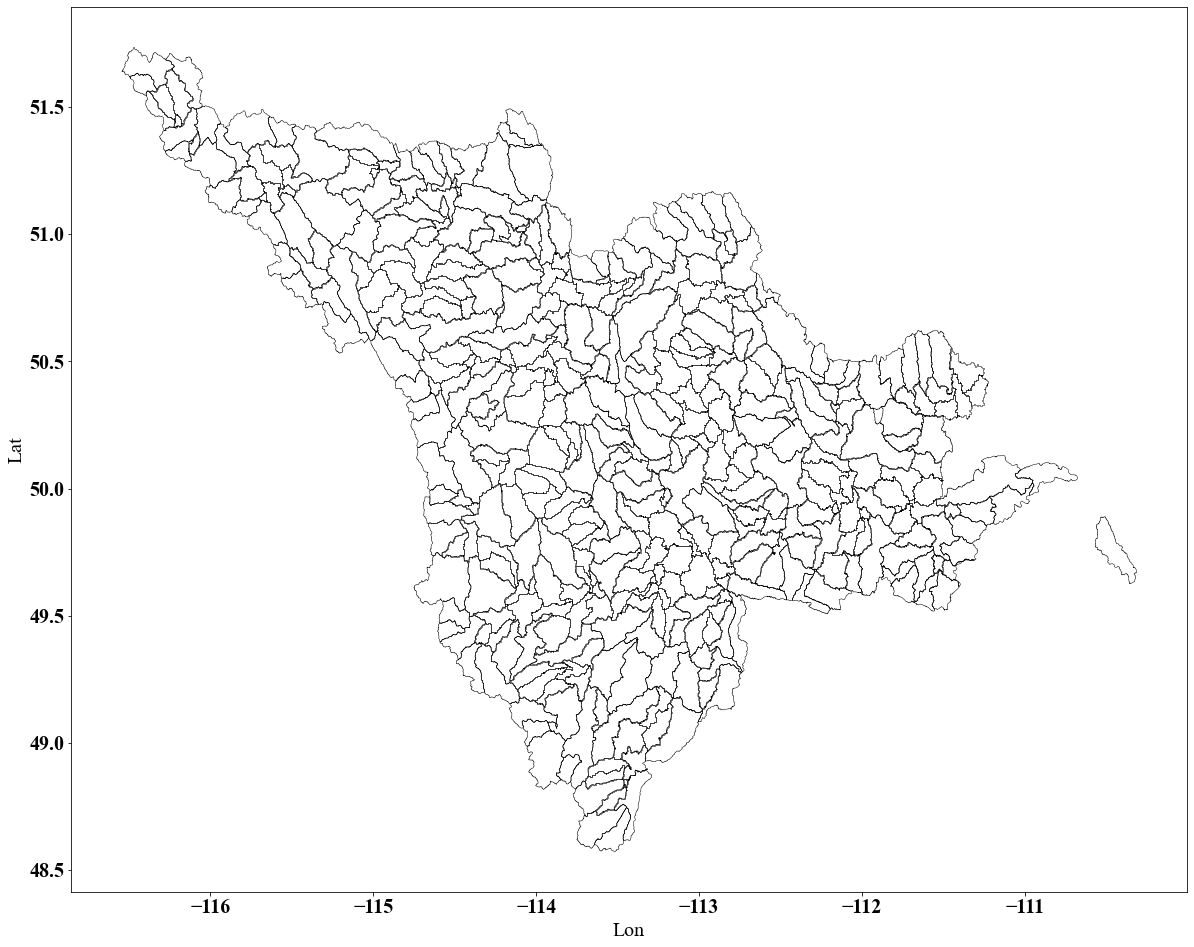

In [1]:
# cell 1: load the shapefile, check the filed or create the necessaary fields
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 20}
matplotlib.rc('font', **font)


# target shapefile is what we want the varibales to be remapped to; South Saskachewan River at Medicine Hat
shp = gpd.read_file('../data/WRF_Bow_at_MedicinHat/target_shp/South_Saskatchewan_MedicineHat.shp')
if (shp.crs != 'epsg:4326'): # check if the projection is WGS84 (or epsg:4326)
    print('please project your shapefile to WGS84 (epsg:4326)')
print(shp.head()) # print the first five row of the shapefile
print(shp.columns) # print existing fields in the shapefile

# plotting
shp.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5, figsize=(20,20))
plt.xlabel('Lon')
plt.ylabel('Lat')

In [2]:
# cell 2: prepare the needed fields; renaming, adding centeroid lat and lon values
shp = shp.rename (columns={'ID':'ID_t'}); # change the COMID to "ID_t" ID from target
shp['lat_t'] = shp.centroid.y # centroid lat from target
shp['lon_t'] = shp.centroid.x # centroid lon from target
print(shp.head()) # show the first 5 rows of the shapefile after renaming and adding centroid
shp.to_file('../data/WRF_Bow_at_MedicinHat/target_shp/South_Saskatchewan_MedicineHat_standard.shp') # save

<ipython-input-2-a70827450124>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lat_t'] = shp.centroid.y # centroid lat from target
<ipython-input-2-a70827450124>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lon_t'] = shp.centroid.x # centroid lon from target


   ID_t        lat         lon  \
0     1  49.627953 -114.565641   
1     2  49.632208 -113.932166   
2     3  50.125601 -113.151587   
3     4  50.200421 -112.791051   
4     5  49.943092 -112.529911   

                                            geometry      lat_t       lon_t  
0  POLYGON ((-114.45500 49.52083, -114.45750 49.5...  49.635051 -114.553877  
1  POLYGON ((-113.92500 49.54333, -113.92500 49.5...  49.629115 -113.934664  
2  POLYGON ((-113.10750 50.12159, -113.10750 50.1...  50.121169 -113.149172  
3  MULTIPOLYGON (((-112.75000 50.17083, -112.7516...  50.191328 -112.796039  
4  POLYGON ((-112.47250 49.98167, -112.46750 49.9...  49.941864 -112.530963  


### The ID_t should be integer and unique, so if any of the below checks fails fix the ID_t so that it is unique for each shape in the shapefile and also integer. The ID_t can be simply from 1 to number of shape in the shapefile.

In [3]:
# cell 3: check if the ID_t are unique for each shapefile and ID_t are all int
# load
shp = gpd.read_file('../data/WRF_Bow_at_MedicinHat/target_shp/South_Saskatchewan_MedicineHat_standard.shp')
if not shp["ID_t"].is_unique:
    print('The shapefile has IDs that are not unique for each shape; fix this issue before continue')
else:
    print('The shapefile has IDs that are unique; continue continue')
if np.array_equal(shp.ID_t, shp.ID_t.astype(int)):
    print('The shapefile has IDs that are integer; continue')
else:
    print('The shapefile has IDs that are not integer; please identify IDs that are integer')
# alternatively user can uncommnet this part:
# shp.ID_t = np.arange(len(shp)) + 1 # adding shapefile ID_t from 1 to n
# shp.to_file('../data/target_shp/Bow_Oldman_standard.shp') # save the file as a standard format or candex


The shapefile has IDs that are unique; continue continue
The shapefile has IDs that are integer; continue


----------------------------
----------------------------
# Step 2: Prepare the shapefile from netCDF file
### The next step is to prepare the shapefile from coordinated (lat/lon) in shapefiles
### The code supports three cases:
### 1- The source netCDF file is in regular lat/lon (this example)
### 2- The source netCDF file has rotated lat/lon meaning that each point has it own lat/lon
### 3- The course netCDF file is irregular and comes with a netCDF file that holds the geospatial information of the netCDF values
### In this example we have a netCDF in regular lat/lon form to subbasin. The netCDF files are saved in daily fashion for 3 days (the first three days of January 1979).
### Assuming the location and extend of all the netCDF files similar we assume that the first shapefile applies to the other netCDF files as well
### <font color='red'>candex support simple change from coordination of 0-360 to -180-180 for convenience. However, this functionality won’t work in areas near lon of 0 where 0 and 360 comes together in the corrent version.</font>

In [4]:
# cell 1: read candex function and load the paraemters
from candex import *
import matplotlib
import numpy as np
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 20}
matplotlib.rc('font', **font)

In [5]:
# cell 2: specifiying the parameter for creating the source shapefile
# name of the sample nc file (give only one if there are separaete file for each year or month)
name_of_nc = '../data/WRF_Bow_at_MedicinHat/source_nc/WRF_merged_2000-10-01.nc'
ds = xr.open_dataset(name_of_nc)
print(ds)
# sample varibale from nc file (similar to all the dimensions for all the varibales with intend to read)
name_of_variable = 'T2' 
# name of varibale in nc file (and not dimension) that holed the longituge values
name_of_lon_var = 'XLONG' 
# name of varibale in nc file (and not dimension) that holds the latitiute values
name_of_lat_var = 'XLAT'
# bounding box the trim the created shepefile
# it should be in form of np.array([min_lat,max_lat,min_lon,max_lon]) 
# or should be give False if there is not box
box_values =  False ; #np.array([47,53,-118,-108])
# if the nc file lon is 0 to 360 and want to transfor to -180 to 180
# in the case the box_value should be in either of east or west hemisphere
correct_360 = False
# name of the shapefile that is created and saved
name_of_shp = '../data/WRF_Bow_at_MedicinHat/source_shp/WRF.shp' 
# creating the shapefile and preparing the 2D lat/lon field based on shapefile for indexing
lat_2D, lon_2D = NetCDF_SHP_lat_lon(name_of_nc, name_of_variable, name_of_lat_var,
                                            name_of_lon_var, name_of_shp, box_values, correct_360)

<xarray.Dataset>
Dimensions:      (time: 24, x: 199, y: 168)
Coordinates:
  * time         (time) datetime64[ns] 2000-10-01 ... 2000-10-01T23:00:00
    XLONG        (y, x) float64 ...
    XLAT         (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    I_RAINNC     (time, y, x) float64 ...
    LWDNB        (time, y, x) float32 ...
    P            (time, y, x) float32 ...
    PREC_ACC_C   (time, y, x) float32 ...
    PREC_ACC_NC  (time, y, x) float32 ...
    Q2           (time, y, x) float32 ...
    RAINC        (time, y, x) float32 ...
    RAINNC       (time, y, x) float32 ...
    SWDNB        (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
case 2 - rotated lat/lon


   ID_s    lat_s     lon_s                                           geometry
0   1.0  46.9102 -118.5370  POLYGON ((-118.53105 46.89252, -118.50516 46.8...
1   2.0  46.9184 -118.4852  POLYGON ((-118.47926 46.90068, -118.45336 46.9...
2   3.0  46.9265 -118.4334  POLYGON ((-118.42746 46.90882, -118.40155 46.9...
3   4.0  46.9346 -118.3816  POLYGON ((-118.37564 46.91694, -118.34972 46.9...
4   5.0  46.9427 -118.3297  POLYGON ((-118.32381 46.92504, -118.29788 46.9...


Text(149.0, 0.5, 'Lat')

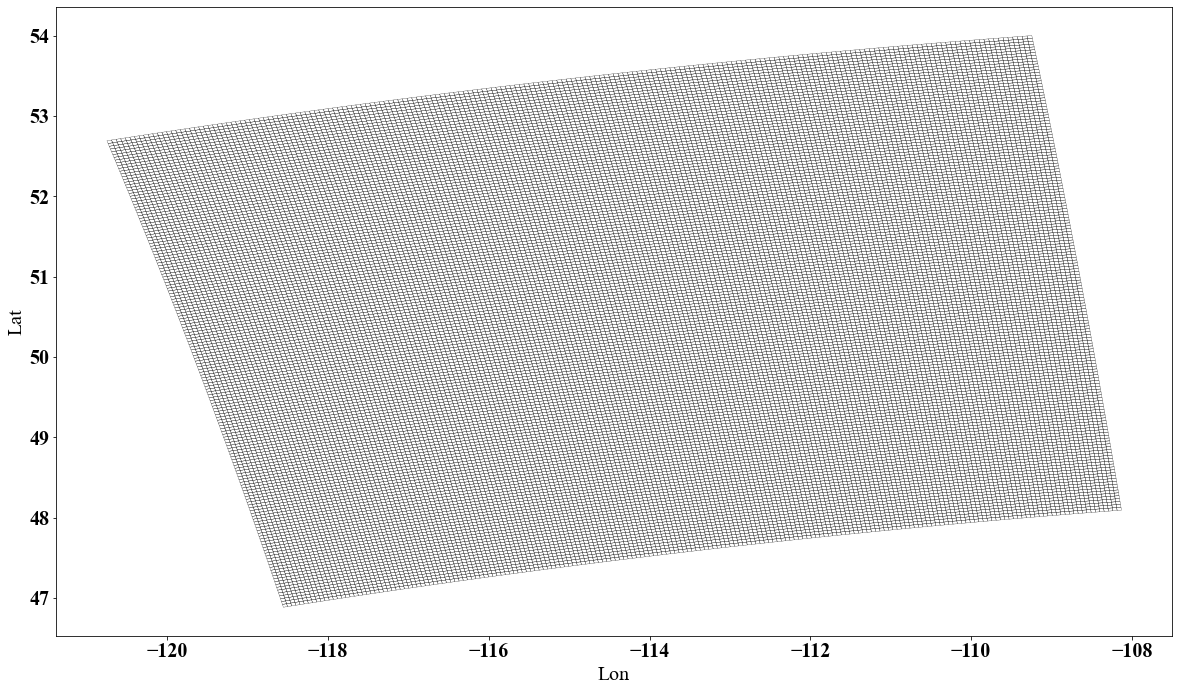

In [6]:
# cell 3: plotting the created shapefile
shp_source = gpd.read_file('../data/WRF_Bow_at_MedicinHat/source_shp/WRF.shp') # load it
print(shp_source.head()) # show the first 5 rows
# plotting
shp_source.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.25, figsize=(20,20))
plt.xlabel('Lon')
plt.ylabel('Lat')

------
------
# Step 3: Intersection of the source and target shapefile and creation of remap data frame
### In this section we intersect the two shapefiles (source and target) to find the percent contribution of source in the target
### We rename the targets to the standard name that it used for candex functions
### <font color='red'>candex assumes that the shapefile from netCDF file is in WGS84 (or EPSG:4326)</font>

In [7]:
# cell 1: Load the candex functions
from candex import *
import matplotlib
import numpy as np
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 20}
matplotlib.rc('font', **font)

/Users/shg096/Desktop/candex_newgen/candex/candex.py:256: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_1['AS1'] = shp_1.area
/Users/shg096/Desktop/candex_newgen/candex/candex.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2['AS2'] = shp_2.area
/Users/shg096/Desktop/candex_newgen/candex/candex.py:341: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
/Users/shg096/Desktop/candex_newgen/candex/candex.py:345: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.Ge

Text(134.0, 0.5, 'Lat')

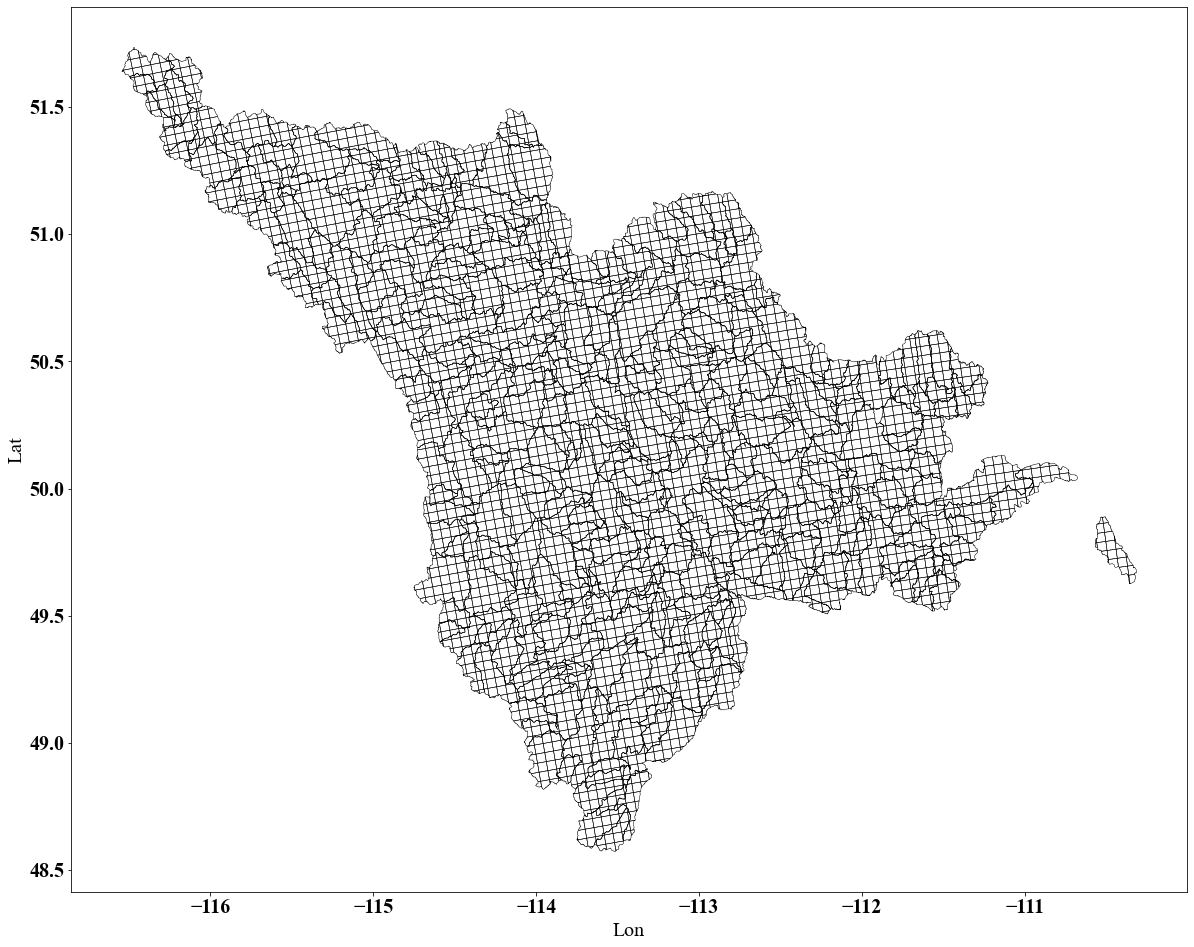

In [8]:
# cell 2: intersection and of source and target shapefiles
shp_target = gpd.read_file('../data/WRF_Bow_at_MedicinHat/target_shp/South_Saskatchewan_MedicineHat_standard.shp') # sload target shp
shp_source = gpd.read_file('../data/WRF_Bow_at_MedicinHat/source_shp/WRF.shp') # load source shp

# assign coordination (here both are defined as WGS1984)
shp_source = shp_source.set_crs("EPSG:4326") # in case if missing

# intersection
shp_int = intersection_shp (shp_target, shp_source)

# rename dictionary
dict_rename = {'S_1_ID_t' : 'ID_t',
               'S_1_lat_t': 'lat_t',
               'S_1_lon_t': 'lon_t',
               'S_2_ID_s' : 'ID_s',
               'S_2_lat_s': 'lat_s',
               'S_2_lon_s': 'lon_s',
               'AP1N'     : 'weight'}

shp_int = shp_int.rename(columns=dict_rename) # rename fields
shp_int = shp_int.sort_values(by=['ID_t']) # sort based on ID_t
shp_int.to_file('../data/WRF_Bow_at_MedicinHat/intersection_shp/WRF_SSR.shp') # save files

# plotting
shp_int.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.5, figsize=(20,20))
plt.xlabel('Lon')
plt.ylabel('Lat')

In [9]:
# cell 2: indexing of the source lat/lon to row and colomns in nc file
remap_df = Dbf5('../data/WRF_Bow_at_MedicinHat/intersection_shp/WRF_SSR.dbf') # load dbf
remap_df = remap_df.to_dataframe()

# find the rows and cols of source in nc file
rows, cols = lat_lon_to_index(np.array(remap_df['lat_s']),
                              np.array(remap_df['lon_s']),
                              lat_2D,
                              lon_2D)
remap_df['rows'] = rows
remap_df['cols'] = cols

# save remap_df as csv for future use
remap_df.to_csv('../data/WRF_Bow_at_MedicinHat/remap/remap_WRF_SSR.csv')

-----
-----
# Step 4: Remap nc file(s)
### Execute the Remapping and write the nc file for each source nc file.
### <font color='red'>The time, calendar, time units, variables units are carried to the remapped nc file from source.</font>

In [10]:
# loading the remap csv
remap_df = pd.read_csv('../data/WRF_Bow_at_MedicinHat/remap/remap_WRF_SSR.csv')

# listing the nc files
nc_names = '../data/WRF_Bow_at_MedicinHat/source_nc/WRF_merged_*.nc' # if there are multiple nc file can be pecify by *
output_path = '../data/WRF_Bow_at_MedicinHat/target_nc/remapped_WRF_SSR_' # the path 
name_of_var_time = 'time' # dimension of time in the source nc files
name_of_vars = ['T2'] #varibale that need to be remapped
# format of the varibales
format_of_vars = ['f4'] # type of the varibale that need to be remapped f4 single, f8 double, int, integer
fill_values = ['-9999.00'] # Fill values for each varibale
authour_name = 'Shervan Gharari, Computational Hydrology Team, The University of Saskatchewan' # the authour

# candex target_nc_creation functions
target_nc_creation(nc_names,
                   remap_df,
                   name_of_var_time,
                   output_path,
                   name_of_vars,
                   format_of_vars,
                   fill_values,
                   authour_name)


Remapping ../data/WRF_Bow_at_MedicinHat/source_nc/WRF_merged_2000-10-01.nc to ../data/WRF_Bow_at_MedicinHat/target_nc/remapped_WRF_SSR_2000-10-01-00-00-00.nc
Started at date and time 2021-01-20 18:38:14.129333
Ended   at date and time 2021-01-20 18:38:14.295229


-----------
-----------
# Step5: Visualization of the result for one time steps for the source and remapped data

In [11]:
# cell 1: Load the candex functions
from candex import *
import matplotlib
import numpy as np
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 20}
matplotlib.rc('font', **font)

<xarray.Dataset>
Dimensions:      (time: 24, x: 199, y: 168)
Coordinates:
  * time         (time) datetime64[ns] 2000-10-01 ... 2000-10-01T23:00:00
    XLONG        (y, x) float64 ...
    XLAT         (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    I_RAINNC     (time, y, x) float64 ...
    LWDNB        (time, y, x) float32 ...
    P            (time, y, x) float32 ...
    PREC_ACC_C   (time, y, x) float32 ...
    PREC_ACC_NC  (time, y, x) float32 ...
    Q2           (time, y, x) float32 ...
    RAINC        (time, y, x) float32 ...
    RAINNC       (time, y, x) float32 ...
    SWDNB        (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...


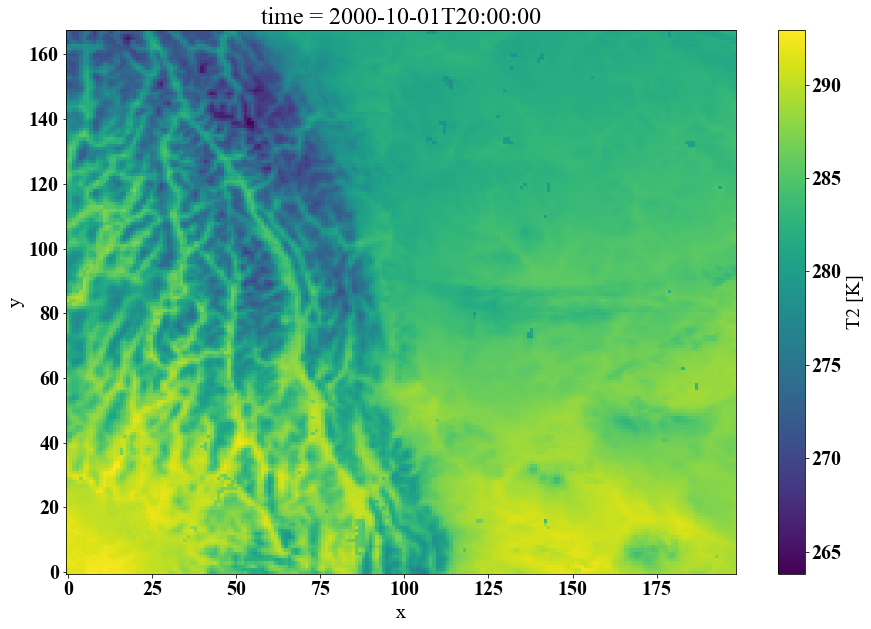

In [12]:
# load the nc file
nc_source  = xr.open_dataset('../data/WRF_Bow_at_MedicinHat/source_nc/WRF_merged_2000-10-01.nc') # nc source
print(nc_source)
nc_source_time  = nc_source.sel(time="2000-10-01T20:00:00",method="nearest") # the first time step
nc_source_time.T2.plot(figsize=(15,10))


Text(164.67988660537327, 0.5, 'Lat')

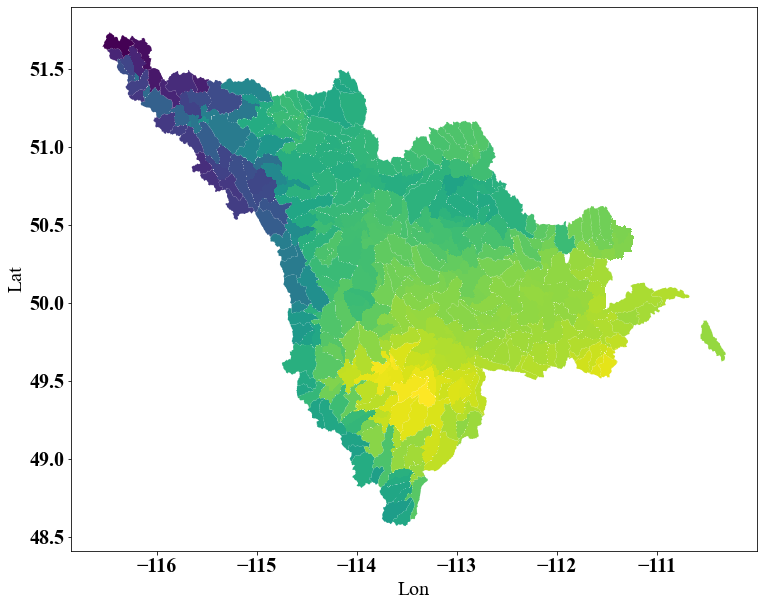

In [14]:
# load a target shapefile and nc file
nc_target  = xr.open_dataset('../data/WRF_Bow_at_MedicinHat/target_nc/remapped_WRF_SSR_2000-10-01-00-00-00.nc') # nc source
nc_target_time = nc_target.sel(time="2000-10-01T20:00:00",method="nearest") # the first time step
air_temp = np.array(nc_target_time.T2)
shp_target = gpd.read_file('../data/WRF_Bow_at_MedicinHat/target_shp/South_Saskatchewan_MedicineHat_standard.shp') # sload target shp
shp_target['airtemp'] = air_temp
shp_target.plot(column='airtemp', figsize=(15,10))
plt.xlabel ('Lon')
plt.ylabel ('Lat')
